In [31]:
from eda_import import *
from scipy import interpolate

# Prepare cov info

In [2]:
%time df_genomecov = pd.read_csv('./results_data/genomecov-by-gene-all-samples.csv.gz', compression='gzip')

CPU times: user 2.33 s, sys: 454 ms, total: 2.79 s
Wall time: 2.79 s


In [4]:
df_genomecov.head(1)

,gene_name,cov_average_num_bases,analysis_id
0,ABL1,83.905369,1d811d54-caa1-41f3-bfc2-400eebdd97ef


In [5]:
df_genomecov.shape

(1216152, 3)

# Prepare clv info

In [7]:
%%time
# the one after clustering has metadata, which is necessary
adf = pd.read_csv('./results_data/all_cba.KLEAT.on-target-cleaned.filtered.clustered.csv.gz',
                  compression='gzip')

CPU times: user 52.7 s, sys: 5.69 s, total: 58.3 s
Wall time: 58.4 s


In [8]:
adf.head(1)

,gene_name,strand,seqname,clv,analysis_id,clv0,hexamer,hexamer_id,hexamer_loc0,hexamer_loc,barcode,disease,disease_name,sample_type,sample_type_name,center,filename,participant_id,sample_id,tss_id,cluster_idx,mclv,aclv,sstype,kid,mkid,akid
0,ABL1,+,chr9,133763062,1d811d54-caa1-41f3-bfc2-400eebdd97ef,133763061,AATAAA,1,133763038,133763039,TCGA-KN-8425-01A-11R-2315-07,KICH,KIDNEY CHROMOPHOBE,TP,Primary solid Tumor,UNC-LCCC,UNCID_2186137.d42c9589-3960-4964-be28-83d275bdc672.121106_UNC11-SN627_0258_AC11WRACXX_6_TGACCA.tar.gz,cc316faf-dcb1-4dea-b8b0-a17d000ff40f,84ed1792-cec8-4f98-9988-74b3f5f6f516,KN,1,133763062,133763062,tumour,chr9|ABL1|+|133763062,chr9|ABL1|+|133763062,chr9|ABL1|+|133763062


In [9]:
assert adf.analysis_id.unique().shape[0] == 10668

In [10]:
adf.columns

Index(['gene_name', 'strand', 'seqname', 'clv', 'analysis_id', 'clv0', 'hexamer', 'hexamer_id', 'hexamer_loc0', 'hexamer_loc', 'barcode', 'disease', 'disease_name', 'sample_type', 'sample_type_name', 'center', 'filename', 'participant_id', 'sample_id', 'tss_id', 'cluster_idx', 'mclv', 'aclv',
       'sstype', 'kid', 'mkid', 'akid'],
      dtype='object')

In [11]:
assert adf.shape[0] == 3420253

In [12]:
assert adf.mkid.unique().shape[0] == 2136

In [15]:
rdf = adf[['seqname', 'gene_name', 'strand', 'mclv', 'disease', 
           'sstype', 'mkid', 'analysis_id']].copy()
rdf.drop_duplicates(inplace=True)

In [16]:
assert rdf.shape[0] == 2213818

In [18]:
rdf.head(1)

,seqname,gene_name,strand,mclv,disease,sstype,mkid,analysis_id
0,chr9,ABL1,+,133763062,KICH,tumour,chr9|ABL1|+|133763062,1d811d54-caa1-41f3-bfc2-400eebdd97ef


In [19]:
10668 * 114

1216152

In [21]:
sdf = rdf[['seqname', 'gene_name', 'strand', 'disease', 'sstype', 'analysis_id']].drop_duplicates()

In [22]:
assert sdf.shape[0] == 1077665

In [23]:
sdf.head(1)

,seqname,gene_name,strand,disease,sstype,analysis_id
0,chr9,ABL1,+,KICH,tumour,1d811d54-caa1-41f3-bfc2-400eebdd97ef


In [24]:
sdf['mclv_detected'] = 1

In [25]:
%time merged = sdf.merge(df_genomecov, on=['analysis_id', 'gene_name'], how='outer')

CPU times: user 1.86 s, sys: 46.3 ms, total: 1.91 s
Wall time: 1.96 s


In [26]:
assert merged.shape[0] == 1216152

In [27]:
merged.fillna(0, inplace=True)

In [28]:
merged.mclv_detected.value_counts()

1.0    1077665
0.0    138487 
Name: mclv_detected, dtype: int64

# Calculate probability of CS predict over coverage

In [41]:
assert merged.shape[0] == 114 * 10668
assert 114 * 10668 == 1216152

98.03% data used
After interpolation, when coverage > 17, the probability goes up to over 90%


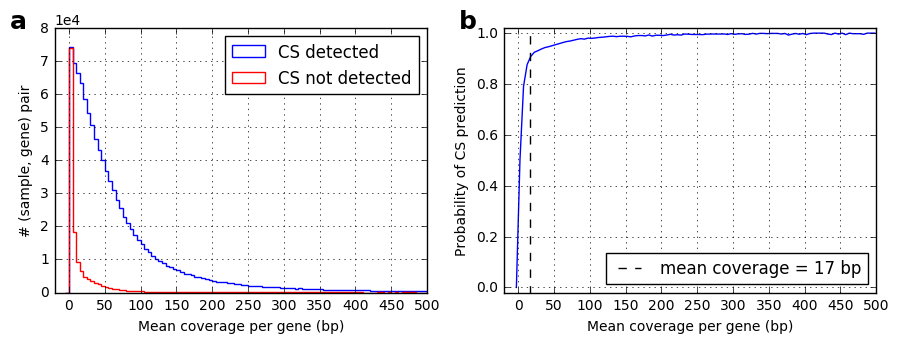

In [46]:
fig = plt.figure(figsize=(9, 3.5))
ax1 = fig.add_subplot(121)

bins = np.arange(-5, 600, 5)
for i, txt, color in zip([1, 0], ['CS detected', 'CS NOT detected'], ['blue', 'red']):
    ax1.hist(merged.query('mclv_detected == {0}'.format(i)).cov_average_num_bases.values, 
            alpha=1, normed=False, bins=bins, color=color, label=txt.replace('NOT', 'not'), histtype='step')
ax1.legend()
ax1.set_xlabel('Mean coverage per gene (bp)')
ax1.set_ylabel('# (sample, gene) pair')
ax1.set_xlim([-20, 500])
ax1.set_xticks(np.arange(0, 501, 50))
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax1.grid()
ax1.text(-0.12, 1, 'a', transform=ax1.transAxes, fontsize=18, fontweight='bold')

on_hist, on_bins = np.histogram(
    merged.query('mclv_detected == 1').cov_average_num_bases.values, bins=bins)
off_hist, off_bins = np.histogram(
    merged.query('mclv_detected == 0').cov_average_num_bases.values, bins=bins)

# not all the data are used because of limited bins for coverage
print('{0:.2%} data used'.format(np.sum(on_hist + off_hist) / (114 * 10668)))

assert (on_bins == off_bins).all()
assert (on_bins == bins).all()

# epsilon: to avoid 0 division error
# epsilon = 1e-6
sensitivities = on_hist / (on_hist + off_hist + 1e-6)
xs = (bins[:-1] + bins[1:]) / 2
ax2 = fig.add_subplot(122)
ax2.plot(xs, sensitivities)
nxs = np.arange(0, 500)
func = interpolate.interp1d(xs, sensitivities)
nys = func(nxs)
cutoff = nxs[nys > 0.9][0]
print('After interpolation, when coverage > {0}, the probability goes up to over 90%'.format(cutoff))
ax2.plot([cutoff, cutoff], [-10, 10], '--', color='k', label='mean coverage = {0} bp'.format(cutoff))
ax2.legend(loc='best')
ax2.set_ylabel('Probability of CS prediction')
# ax2.scatter(xs[:5], sensitivities[:5])
ax2.set_xlabel('Mean coverage per gene (bp)')
ax2.set_ylabel('Probability of CS prediction')
ax2.set_xlim(-20, 500)
ax2.set_ylim(-0.02, 1.02)
ax2.set_xticks(np.arange(0, 501, 50))
ax2.grid()
ax2.text(-0.12, 1, 'b', transform=ax2.transAxes, fontsize=18, fontweight='bold')

plt.tight_layout()
# plt.savefig('./results/figs/hist_of_gene_coverages_when_clv_on_off.png', dpi=500)